In [1]:
import pandas as pd
df=pd.read_csv('data.csv')

In [2]:
### define outliers 
mean = df['ncp'].mean()
std_dev = df['ncp'].std()
df['Outlier'] = (df['ncp'] < mean - 10*std_dev) | (df['ncp'] > mean + 10*std_dev)

### drop outliers 

df = df.drop(df[df['Outlier'] == True].index)


### drop nan

print(df.isnull().sum())
df = df.dropna() 

Unnamed: 0       0
iso              0
crsID            0
Lat              0
Lon              0
Yr               0
Mn               0
Dy               0
salt             0
temp             0
press            0
o2ar             0
neto2            0
Lon70            0
yrmn             0
jd               0
wsi              0
wsj              0
yd               0
mli              0
mlj              0
ncp           1615
CbPM             0
VGPM             0
CDOM             0
CHL              0
KD490            0
PAR              0
PIC              0
POC              0
aot              0
Rrs_412          0
Rrs_443          0
Rrs_490          0
Rrs_510          0
Rrs_555          0
Rrs_670          0
ID               0
Outlier          0
dtype: int64


### Generalized Method of Moments (GMM) estimator 

In [22]:
feature_columns = [ 'Lat', 'Lon', 'Yr', 'Mn', 'Dy', 'salt',
       'temp', 'press', 'neto2', 'Lon70', 'yrmn', 'jd', 'wsi', 'wsj',
       'yd', 'mli', 'mlj', 'CbPM', 'VGPM', 'CDOM', 'CHL', 'KD490',
       'PAR', 'PIC', 'POC', 'aot', 'Rrs_412', 'Rrs_443', 'Rrs_490', 'Rrs_510',
       'Rrs_555', 'Rrs_670']

In [38]:
# Sort data by longitude
df_sorted = df.sort_values(by='Lon')

# Define dependent variable and independent variables
y = df_sorted['ncp']
X = df_sorted[feature_columns]

# Determine split point
split_point = int(len(df_sorted) * 0.8)

# Split the data
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]
# assign column name 

X_train.columns = feature_columns
X_test.columns = feature_columns

In [18]:
print(y_train.nunique()) 


282274


In [39]:
from pysal.lib import weights
from pysal.explore import esda
from pysal.model import spreg
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# create spatial weights matrix
coordinates_train = X_train[['Lat', 'Lon']].values

#  spatial weights matrix using K nearest neighbors
w_train = weights.KNN.from_array(coordinates_train, k=3)
### having issue that there is  there are groups of observations which are not connected to each other spatially


mi = esda.Moran(y_train, w_train)
print(f"Moran's I: {mi.I}, p-value: {mi.p_sim}")

# # add constant to independent variables
# X_const = spreg.add_constant(X_train)  # or use X = sm.add_constant(X) if using statsmodels


model = spreg.GM_Lag(y_train.values[:, None], X_train.values, w=w_train)
print(model.summary)

/hpc/home/xc184/.local/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 1639 disconnected components.
  warnings.warn(message)


Moran's I: 0.9967419819960229, p-value: 0.001
REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:      282941
Mean dependent var  :      9.2043                Number of Variables   :          34
S.D. dependent var  :     23.2837                Degrees of Freedom    :      282907
Pseudo R-squared    :      0.0657
Spatial Pseudo R-squared:  0.1346

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    -203029.4066858             nan             nan             nan
               var_1      -5.4026682       0.0523080    -103.2856478       0.0000000
          

nan values in the Std.Error and Probability columns
- Correlation matrix
- Variance Inflation Factor (VIF) analysis
- Feature Scaling

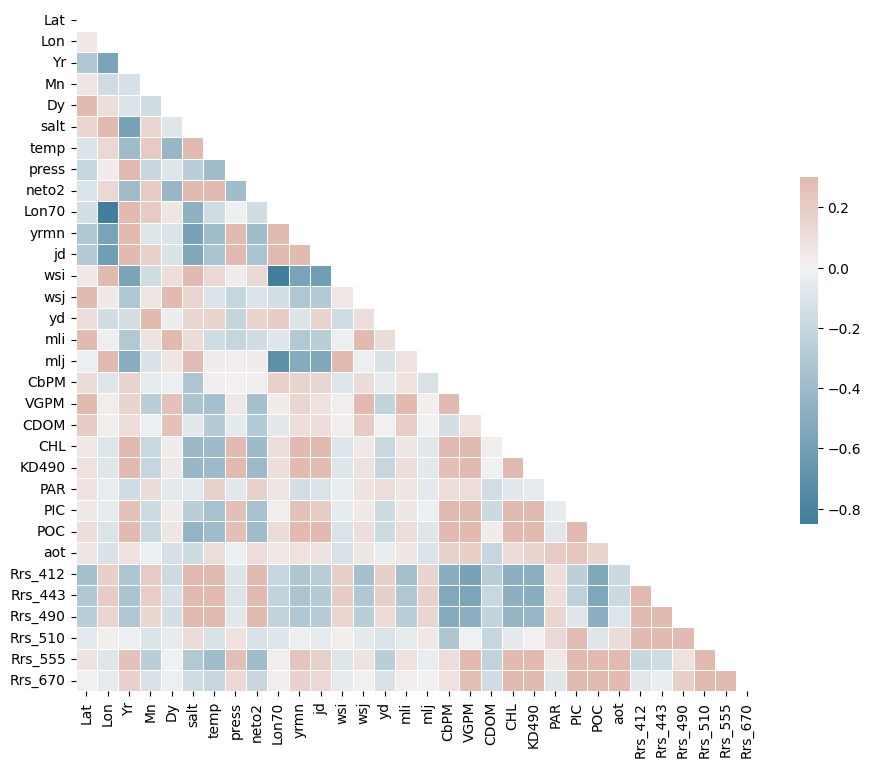

In [41]:

### Correlation matrix

import seaborn as sns
import matplotlib.pyplot as plt

# correlation matrix
corr = X_train.corr()

# upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()



Moran's I is a measure of global spatial autocorrelation. It ranges from -1 (indicating perfect dispersion) through 0 (random pattern) to +1 (perfect correlation).------>indicates a very high positive spatial autocorrelation

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["Variables"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif)


   Variables           VIF
0        Lat  3.481075e+04
1        Lon  2.592683e+04
2         Yr           inf
3         Mn  9.007199e+15
4         Dy  9.570224e+03
5       salt  4.371184e+00
6       temp           inf
7      press  2.395632e+00
8      neto2           inf
9      Lon70  1.140238e+01
10      yrmn           inf
11        jd  2.070382e+08
12       wsi  2.585576e+04
13       wsj  3.558267e+04
14        yd  6.111902e+05
15       mli  4.923720e+02
16       mlj  8.161463e+01
17      CbPM  2.369728e+00
18      VGPM  2.670844e+00
19      CDOM  2.702124e+00
20       CHL  7.426801e+00
21     KD490  5.548521e+00
22       PAR  2.835462e+00
23       PIC  6.845593e+00
24       POC  3.524526e+00
25       aot  1.468673e+00
26   Rrs_412  2.583756e+02
27   Rrs_443  3.843852e+02
28   Rrs_490  7.335333e+01
29   Rrs_510  1.982892e+01
30   Rrs_555  2.538510e+01
31   Rrs_670  6.771733e+00


In [3]:
feature_columns = [ 'Lat', 'Lon', 'salt',
       'temp', 'press', 'neto2', 'Lon70', 'yrmn', 'jd', 'wsi', 'wsj','mli', 'CbPM', 'VGPM', 'CDOM', 'KD490',
       'PAR','POC', 'aot', 'Rrs_412', 'Rrs_443','Rrs_510']

In [52]:
vif = pd.DataFrame()
vif["Variables"] = X_train_scaled.columns
vif["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(X_train_scaled.shape[1])]


In [53]:
print(vif)

   Variables           VIF
0        Lat  3.467595e+04
1        Lon  2.585541e+04
2       salt  4.235719e+00
3       temp           inf
4      press  1.955840e+00
5      neto2           inf
6      Lon70  5.358327e+00
7       yrmn  2.318753e+01
8         jd  1.878910e+01
9        wsi  2.579134e+04
10       wsj  3.544714e+04
11       mli  4.899074e+02
12       mlj  8.120546e+01
13      CbPM  1.904676e+00
14      VGPM  2.553423e+00
15      CDOM  2.608926e+00
16     KD490  2.081339e+00
17       PAR  1.420680e+00
18       POC  2.369790e+00
19       aot  1.389280e+00
20   Rrs_412  1.869230e+02
21   Rrs_443  2.001275e+02
22   Rrs_510  1.038223e+01
23   Rrs_555  8.940000e+00


In [4]:
# Sort data by longitude
df_sorted = df.sort_values(by='Lon')

# Define dependent variable and independent variables
y = df_sorted['ncp']
X = df_sorted[feature_columns]

# Determine split point
split_point = int(len(df_sorted) * 0.8)

# Split the data
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]
# assign column name 

X_train.columns = feature_columns
X_test.columns = feature_columns

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [17]:
from pysal.lib import weights
from pysal.explore import esda
from pysal.model import spreg
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# create spatial weights matrix
coordinates_train = X_train_scaled[['Lat', 'Lon']].values

#  spatial weights matrix using K nearest neighbors
w_train = weights.KNN.from_array(coordinates_train, k=5)

### having issue that there is  there are groups of observations which are not connected to each other spatially


mi = esda.Moran(y_train, w_train)
print(f"Moran's I: {mi.I}, p-value: {mi.p_sim}")

# # add constant to independent variables
# X_const = spreg.add_constant(X_train)  # or use X = sm.add_constant(X) if using statsmodels


model = spreg.GM_Lag(y_train.values[:, None], X_train_scaled.values, w=w_train)
print(model.summary)

/hpc/home/xc184/.local/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 872 disconnected components.
  warnings.warn(message)


Moran's I: 0.9961291569891, p-value: 0.001
REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:      282941
Mean dependent var  :      9.2043                Number of Variables   :          24
S.D. dependent var  :     23.2837                Degrees of Freedom    :      282917
Pseudo R-squared    :      0.3324
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    -1044554.5049163    1956.3367773    -533.9338896       0.0000000
               var_1    -893.7259199     475.2687478     

In [28]:
from sklearn.metrics import mean_squared_error as mse

# Predict values for train set
y_train_pred = model.predy_e.flatten()

# Compute Mean Squared Error for train set
mse_train = mse(y, y_train_pred)

print("Training MSE:", mse_train)


Training MSE: 696.8524413637609


In [26]:
print(y_train.shape)         # Shape of y_train
print(y_train_pred.shape)    # Shape of y_train_pred


(282941,)
(353677,)


In [27]:
len(y)

353677

In [9]:
import numpy as np
from pykrige.ok import OrdinaryKriging

# # Prepare your data
# observed_data = np.column_stack((X_train_scaled[['Lat', 'Lon']].values, y_train.values))  # Combine coordinates and target variable
# observed_coordinates = observed_data[:, :2]
# observed_values = observed_data[:, 2]

# prediction_coordinates = X_test_scaled[['Lat', 'Lon']].values

from scipy.spatial import cKDTree

# Create a KDTree from the input coordinates
tree = cKDTree(X_train_scaled[['Lat', 'Lon']].values)

# Query the tree to find the k nearest neighbors for each point
distances, indices = tree.query(X_train_scaled[['Lat', 'Lon']].values, k=3)

# Use the distances and indices to calculate the variogram model
ok = OrdinaryKriging(
    X_train_scaled['Lat'].values,
    X_train_scaled['Lon'].values,
    y_train.values,
    variogram_model='linear',
    coordinates_type='geographic',
    nlags=10
)


# # Perform kriging interpolation
# ok = OrdinaryKriging(
#     observed_coordinates[:, 1],  # Longitude values
#     observed_coordinates[:, 0],  # Latitude values
#     observed_values,
#     variogram_model="linear",  # Choose a variogram model (e.g., linear, exponential, spherical)
#     verbose=False
# )

kriging_results, kriging_error = ok.execute(
    "points",  # Specify the output grid type ("points" for point-wise predictions)
    prediction_coordinates[:, 1],  # Longitude values of prediction coordinates
    prediction_coordinates[:, 0],  # Latitude values of prediction coordinates
)

# Retrieve the predicted ncp values
predicted_ncp = kriging_results.data[:, 0]

# Print the predicted ncp values
for i, (lat, lon) in enumerate(prediction_coordinates):
    print(f"Predicted ncp at ({lat}, {lon}): {predicted_ncp[i]}")


MemoryError: Unable to allocate 596. GiB for an array with shape (282941, 282941) and data type float64

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# Define the number of nearest neighbors for IDW interpolation
k = 3

# Compute pairwise distances between the training points and test points
distances = euclidean_distances(X_train_scaled[['Lat', 'Lon']].values, X_test_scaled[['Lat', 'Lon']].values)

# Find the indices of the k nearest neighbors for each test point
indices = np.argpartition(distances, k, axis=0)[:k]

# Compute the inverse distances for IDW interpolation
inverse_distances = 1.0 / distances[indices]

# Compute the weighted average of the target variable for each test point
y_pred = np.average(y_train.values[indices], weights=inverse_distances, axis=0)

# Calculate the evaluation metrics (e.g., RMSE, R^2) for the IDW model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")
